<h2>Experimenting with redshift transformations</h2>

Here we are experimenting with the flux corrections associated with redshif. For a spectrum expressed in $f_{\nu}$ units, "photon energies and arrival rates are redshifted, reducing the flux density by a factor $(1+z)^2$; opposing this, the bandwidth $d_{\nu}$ is reduced by a factor $(1+z)$, so the energy flux per unit bandwidth goes down by one power of $(1+z)$; finally, the observed photons at frequency $\nu_{0}$ were emitted at frequency $\nu_{0}(1+z)$, so the flux density is the luminosity at this frequency, divided by the total area, divided by $(1+z)$" (https://ned.ipac.caltech.edu/level5/Peacock/Peacock3_4.html)

From this, we infer that if a spectrum is expressed in photnu units, flux density  is invariant with redshift, because the redshift terms cancel each other (in the above reasoning, we are now counting photons and not photon energies, so one of the $(1+z)$ terms does not appear). By the same token, flux density in $f_{\lambda}$ units decreases by a factor $(1+z)^{3}$ because the bandwidth $d_{\lambda}$ increases by $(1+z)$. 

We can accomodate transformation for all flux density units in a single, generic transformation, where we first convert the fluxes to photnu, then recalculate the wavelengths associated with each spectrum point, and then convert fluxes back to their original units. 

The alternative is to scale flux density directly by multiplying by the appropriate factor $(1+z)^{n}$, where {n = 0, -1, -2, ...} depending on the units of the spectrum, and the target units in case we want to combine the redshift operation with a units conversion operation. We still have to figure out how to handle bandwidths expressed in energy units (eV), and the $n$ factors to use with other units such as Jy, Watt, $\nu f_{\nu}$, $phot f_{\lambda}$, ABMAG, and all other combinations. With the units conversion method above, all of this is included already. 

<h3>1 - Converting data to redshift z</h3>

In [1]:
from __future__ import print_function

import numpy as np
from astropy.io import fits
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

# constants for plotting
micron_label = '$\lambda$($\mu$)'
angstrom_label = '$\lambda$($\AA$)'
fnu_label = 'erg.cm$^{-2}$.s$^{-1}$.$Hz^{-1}$'
flambda_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [0.8, 2.4, 2.8e-15, 4.e-15]

# read data
data = np.genfromtxt("data/example_spec_ipac.txt")
wave = data[:,0]
flux = data[:,1]

# define some units
micron = u.micron
photnu = u.photon/u.cm**2/u.s/u.Hz
fnu = u.erg/u.cm**2/u.s/u.Hz 
flambda = u.erg/u.cm**2/u.s/u.AA

In [2]:
# redshift value for testing
z = 0.5

# build redshifted wavelength array
wave_r = (1.+z) * (wave)

# this spectrum is actually expressed in flam units. Here we fake
# that it is expressed in fnu instead, because we know that fnu
# scales with 1/(1+z) with the redshift (see above) so we can
# verify that our transformation does it correctly.
flux_units = fnu

# get a reference wavelength that makes sense for this particular data set. 
# Anything would actually work in here.
wave_mean = np.mean(wave)

# apply flux correction for redshifted flux density
a = (flux * flux_units).to(photnu, equivalencies=u.spectral_density(wave_mean * micron)) 
flux_r = a.to(flux_units, equivalencies=u.spectral_density((1.+z) * wave_mean * micron))

# Compute total flux in input and redshifted spectrum. We know that flux 
# density (in fnu units) decreases by a factor (1+z) on the redshifted 
# spectrum. Since the wavelength bins used in the integration stretch by 
# the same factor, integrating over the sampled spectrum should preserve 
# total flux.
delta = wave[1:] - wave[:-1]
sum_f = np.sum(flux[1:] * delta)
print("Total flux of input spectrum = %g" % sum_f)
delta = wave_r[1:] - wave_r[:-1]
sum_f = np.sum(flux_r[1:].value * delta) 
print("Total flux of redshifted spectrum at z=%4.2f = %g" % (z, sum_f))

Total flux of input spectrum = 1.22286e-14
Total flux of redshifted spectrum at z=0.50 = 1.22286e-14


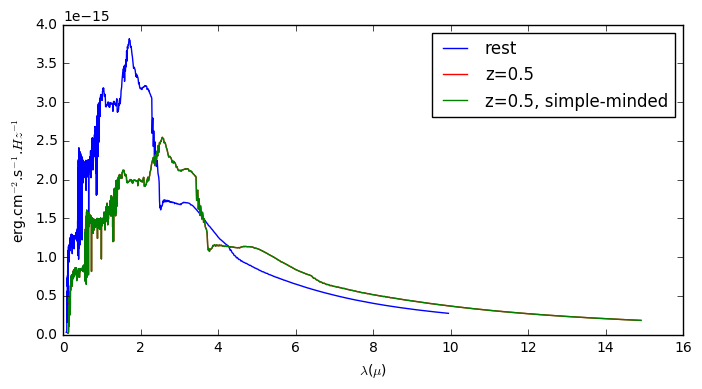

In [3]:
# we see that in this particular case, just scaling fluxes by
# 1/(1+z) correctly transforms the spectrum.
plt.gcf().set_size_inches(8.,4.)
plt.plot(wave, flux, color='b', label='rest')
plt.plot(wave_r, flux_r, color='r', label='z='+str(z))
plt.plot(wave_r, flux/(1.+z), color='g', label='z='+str(z)+', simple-minded')
plt.xlabel(micron_label)
plt.ylabel(fnu_label)
plt.legend()

In [4]:
# now we use the actual units for this spectrum
flux_units = flambda

# and repeat the above
a = (flux * flux_units).to(photnu, equivalencies=u.spectral_density(wave_mean * micron)) 
flux_r = a.to(flux_units, equivalencies=u.spectral_density((1.+z) * wave_mean * micron))

delta = wave[1:] - wave[:-1]
sum_f = np.sum(flux[1:] * delta)
print("Total flux of input spectrum = %g" % sum_f)
# Now, we know that flux density expressed in flam decreases by a factor (1+z)**3, so
# for comparison with the rest spectrum, we correct the integral by a factor (1+z)**2 
delta = wave_r[1:] - wave_r[:-1]
sum_f = np.sum(flux_r[1:].value * delta) * (1.+z)**2
print("Total flux of redshifted spectrum at z=%4.2f, corrected by (1.+z)^2 = %g" % (z, sum_f))

Total flux of input spectrum = 1.22286e-14
Total flux of redshifted spectrum at z=0.50, corrected by (1.+z)^2 = 1.22286e-14


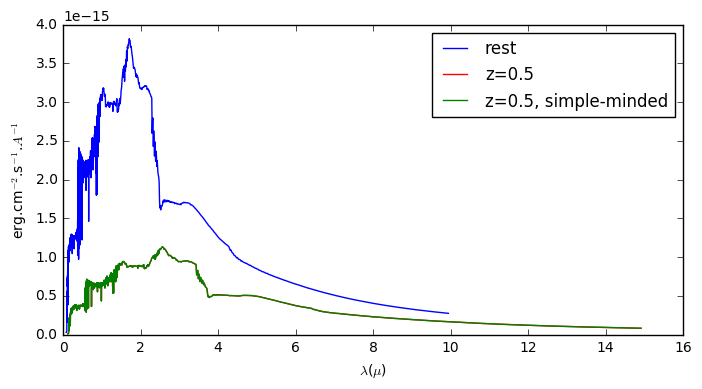

In [5]:
# now, got to scale by 1/(1+z)**3 to get it right
plt.gcf().set_size_inches(8.,4.)
plt.plot(wave, flux, color='b', label='rest')
plt.plot(wave_r, flux_r, color='r', label='z='+str(z))
plt.plot(wave_r, flux/((1.+z)**3), color='g', label='z='+str(z)+', simple-minded')
plt.xlabel(micron_label)
plt.ylabel(flambda_label)
plt.legend()

Total flux of rest spectrum = 2.9997e-05
Total flux of redshifted spectrum at z=0.50, corrected by (1.+z)^2 = 2.9997e-05


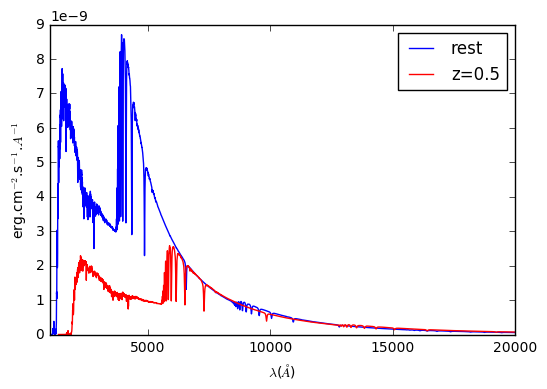

In [6]:
# use pysynphot to independently verify the above computations

import pysynphot as S

vega = S.Vega
delta = vega.wave[1:] - vega.wave[:-1]
sum_f = np.sum(vega.flux[1:] * delta)
print("Total flux of rest spectrum = %g" % sum_f)
plt.plot(vega.wave, vega.flux, label='rest')

# Vega spectrum is expressed in flam units. We convert to 
# photnu units so flux density becomes invariant under 
# redshift transformations. Then we convert back to original
# flam units. 
z = 0.5
vega = S.Vega
vega.convert('photnu') 
vega = vega.redshift(z)
vega.convert('flam') 
delta = vega.wave[1:] - vega.wave[:-1]
sum_f = np.sum(vega.flux[1:] * delta) * (1.+z)**2
print("Total flux of redshifted spectrum at z=%4.2f, corrected by (1.+z)^2 = %g" % (z, sum_f))
plt.plot(vega.wave, vega.flux, color='r', label='z='+str(z))
plt.xlabel(angstrom_label)
plt.ylabel(flambda_label)
plt.xlim(1000, 20000)
plt.legend()

<h3>2 - Converting models to/from redshift z  -  UNDER CONSTRUCTION   </h3>

Here we experiment with the model composition method to handle redshifts in the astropy context, including the issue of flux density corrections.